# <center> Working with geometries </center>


In this notebook, we explore ways to sharpen a polygon's edges, i.e. break the contour of a polygon into a certain number of segments rather than a curvy line (or lots and lots of small segments).

The goal is to post-process the polygons returned by Mask R-CNN applied to solar panels segmentation, so that they become closer to reality - indeed, mask outputs can have curvy edges, even when we try to detect sharp shapes such as solar panels.

Based on the experiments run in this notebook, I added post-processing functions to `solar.py` to compute the concave hull (or "alpha shape") of each detected solar panel polygon through Delaunay triangulation. The functions work, and now need to be tested in the solar panel app.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shapely
from scipy.spatial import Delaunay
import numpy as np
import math
from descartes import PolygonPatch
import fiona
from matplotlib.collections import LineCollection
import geopandas as gpd
import random

In [2]:
polyfile = gpd.read_file("/Users/Thomas/Documents/Data Science X/Stage/Total/Arbres/Data/export.geojson")

In [6]:
def plot_polygon(polygon):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    margin = 0

    x_min, y_min, x_max, y_max = polygon.bounds

    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999', ec='#000000', fill=True, zorder=-1)
    ax.add_patch(patch)
    return fig

### Shapely manipulations

* Base polygon

array('d', [5.6313994, 5.6308975, 5.6306871, 5.6312289, 5.631244, 5.6310338, 5.6294783, 5.6278067, 5.6271294, 5.6258002, 5.6250372, 5.6243996, 5.6237822, 5.6228888, 5.6228485, 5.623541, 5.6249912, 5.6259645, 5.6270185, 5.6271986, 5.627128, 5.6259933, 5.6254617, 5.6261477, 5.6275904, 5.6289165, 5.6297026, 5.6305793, 5.6315787, 5.6327861, 5.633898, 5.6337927, 5.6323526, 5.6311371, 5.6312577, 5.6313994])


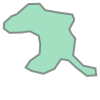

In [46]:
poly = polyfile.geometry[1]
x, y = poly.exterior.coords.xy
print(x)
poly

* minimum_rotated_rectangle

array('d', [5.8812221054090905, 5.9099295004802705, 5.903645765905573, 5.874938370834393, 5.8812221054090905])


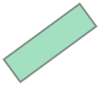

In [4]:
poly2 = poly.minimum_rotated_rectangle
polyfile.geometry[0] = poly2
x2, y2 = poly2.exterior.coords.xy
print(x2)
poly2

* Convex hull

array('d', [5.8815758, 5.8792472, 5.8787796, 5.8792007, 5.8810035, 5.8856223, 5.8869745, 5.8984287, 5.8999104, 5.9005725, 5.9051515, 5.9057271, 5.9080705, 5.904846, 5.9020659, 5.8827804, 5.8823642, 5.8819308, 5.8817994, 5.8815758])


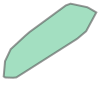

In [5]:
poly3 = poly.convex_hull
polyfile.geometry[0] = poly3
x3, y3 = poly3.exterior.coords.xy
print(x3)
poly3

### Fill-in polygon with random points

In [47]:
def generate_points_in_polygon(number, polygon):
    list_of_points = []
    minx, miny, maxx, maxy = polygon.bounds
    counter = 0
    while counter < number:
        pnt = shapely.geometry.Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            list_of_points.append(pnt)
            counter += 1
    return list_of_points

In [59]:
poly_random = generate_points_in_polygon(200, poly)

In [60]:
poly_random

In [61]:
x_rand = [poly_r.coords[0][0] for poly_r in poly_random]
y_rand = [poly_r.coords[0][1] for poly_r in poly_random]

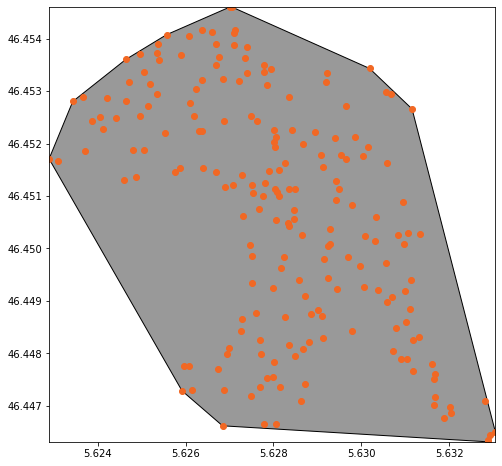

In [62]:
point_collection = shapely.geometry.MultiPoint(list(poly_random))
_ = plot_polygon(point_collection.convex_hull)
_ = plt.plot(x_rand,y_rand,'o', color='#f16824')

### Concave hull (alpha shape by Delaunay triangulation)

In [63]:
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull

    coords = np.array([point.coords[0] for point in points])
    tri = Delaunay(coords)
    triangles = coords[tri.vertices]
    a = ((triangles[:,0,0] - triangles[:,1,0]) ** 2 + (triangles[:,0,1] - triangles[:,1,1]) ** 2) ** 0.5
    b = ((triangles[:,1,0] - triangles[:,2,0]) ** 2 + (triangles[:,1,1] - triangles[:,2,1]) ** 2) ** 0.5
    c = ((triangles[:,2,0] - triangles[:,0,0]) ** 2 + (triangles[:,2,1] - triangles[:,0,1]) ** 2) ** 0.5
    s = ( a + b + c ) / 2.0
    areas = (s*(s-a)*(s-b)*(s-c)) ** 0.5
    circums = a * b * c / (4.0 * areas)
    filtered = triangles[circums < (1.0 / alpha)]
    edge1 = filtered[:,(0,1)]
    edge2 = filtered[:,(1,2)]
    edge3 = filtered[:,(2,0)]
    edge_points = np.unique(np.concatenate((edge1,edge2,edge3)), axis = 0).tolist()
    m = shapely.geometry.MultiLineString(edge_points)
    triangles = list(shapely.ops.polygonize(m))
    return shapely.ops.cascaded_union(triangles), edge_points

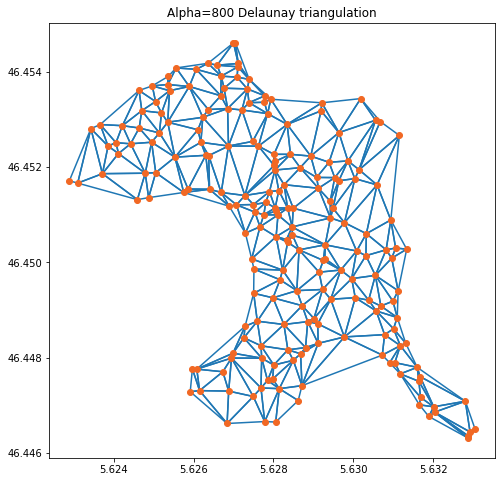

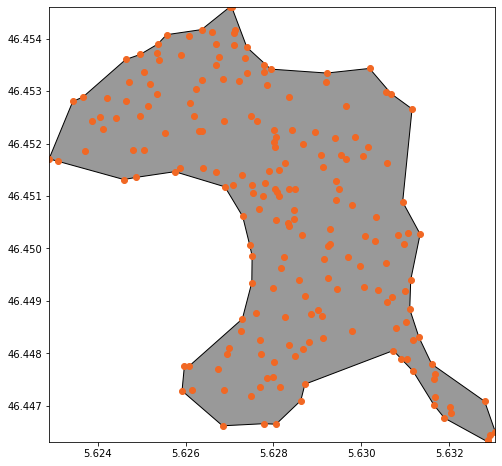

In [72]:
alpha = 800
concave_hull, edge_points = alpha_shape(poly_random, alpha=alpha)

#print concave_hull
lines = LineCollection(edge_points)
plt.figure(figsize=(8,8))
plt.title('Alpha={0} Delaunay triangulation'.format(alpha))
plt.gca().add_collection(lines)
delaunay_points = np.array([point.coords[0] for point in poly_random])
plt.plot(delaunay_points[:,0], delaunay_points[:,1], 'o', color='#f16824')

_ = plot_polygon(concave_hull)
_ = plt.plot(x_rand,y_rand,'o', color='#f16824')

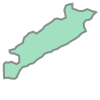

In [43]:
concave_hull

In [44]:
len(edge_points)

5691

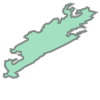

In [45]:
poly